# **ThermoModel**
----------------------


Welcome to my Bitcoin Price Analysis Jupyter Notebook, where I created the **ThermoModel** to evaluate and predict Bitcoin's price movements based on historical data. 
The aim of this analysis is to provide a statistical foundation for understanding Bitcoin’s price growth over time and to develop predictive models that can be useful for traders and investors.



# Introduction
----------------------


Bitcoin, the first decentralized digital currency, has captivated financial analysts with its volatile market dynamics. This notebook introduces a novel approach by using an ensemble model that combines both cubic and logarithmic regressions. This ensemble model is optimized to predict future price tops and bottoms more accurately.


### Objectives


1.  **Data Loading**: Import and preprocess Bitcoin price data, using 95% of the data for training to ensure comprehensive model training and validation.
2.  **Model Development**: Develop cubic and logarithmic regression models to analyze price trends.
3.  **Ensemble Model Optimization**: Enhance model predictions by optimizing an ensemble model that integrates outputs from both regression models.
4.  **Prediction and Visualization**: Use the optimized ensemble model to forecast future prices and visualize the results through dynamic and informative plots.


### Tools and Libraries


This notebook utilizes Python libraries such as Pandas for data manipulation, Matplotlib for plotting, Scikit-Learn for regression modeling, statsmodels for statistical modeling, and scipy for scientific computing which includes optimization routines. It also incorporates custom functions from an imported module designed specifically for processing Bitcoin price data.


### Dataset


The dataset includes historical price data of Bitcoin and is loaded through a custom function that prepares the data by handling missing values and segmenting it based on the specified training fraction.

Let's begin by setting up the environment and loading the necessary data to kick off the analysis.

In [1]:
import pandas as pd
import sys
sys.path.append("/Users/danieleraimondi/bitcoin_datascience/functions")

from functions_ThermoModel import (
    load_btc_data,
    cubic_regression,
    logarithmic_regression,
    optimize_params,
    weight_plot,
    final_plot, 
    inference
)

import warnings
warnings.filterwarnings("ignore")


df, last_date = load_btc_data(train_frac = 0.95, last_date = True)

# Cubic Regression Model
----------------------

In this section, I perform a cubic regression on the Bitcoin price data. 

The cubic regression helps us understand the non-linear dynamics of Bitcoin prices over time. I compute upper and lower bounds that provide insights into potential future price movement areas.

$$
log(1 + \text{PriceUSD})  = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3
$$



### Parameters:

*   **upper**: Adjusts the upper bound for the regression.
*   **lower**: Adjusts the lower bound for the regression.
*   **visualize\_plot**: Set to `False` as I focus on capturing the model parameters for further analysis rather than visualizing the plot in this step.





I will store the output in `df`, which will include the new columns for the regression bounds, and `cubic_model_params`, which will capture the coefficients and intercept from the cubic regression model. These parameters will be used for our ensemble model.

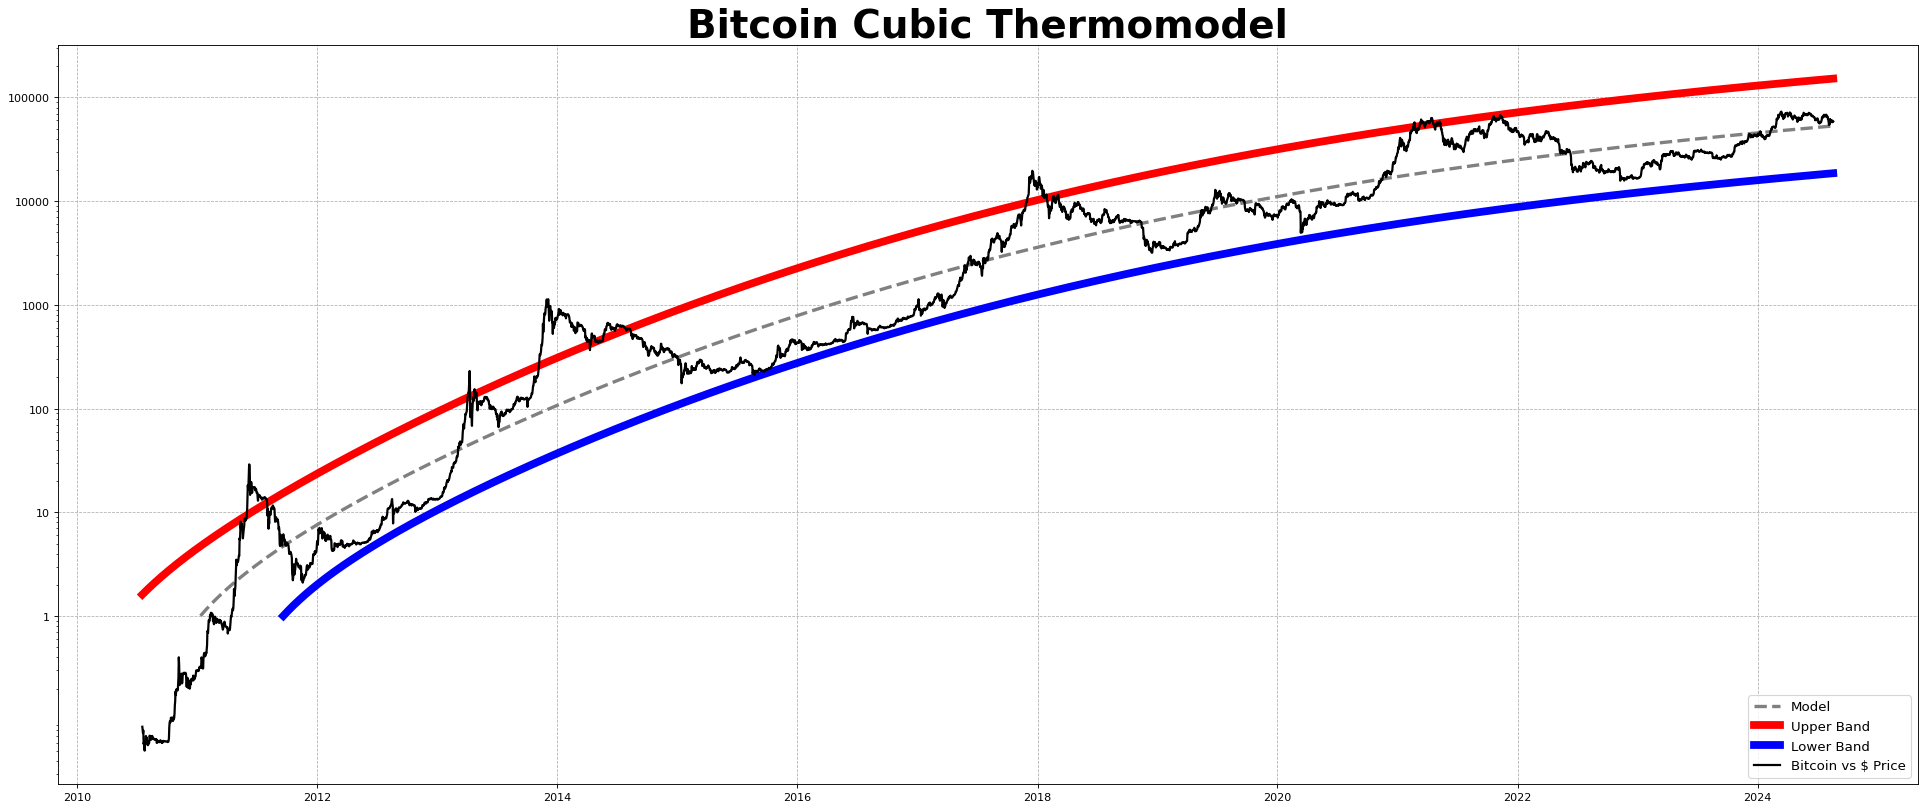

Fitted parameters on train data: {'degrees': 3, 'coef': [0.0, 0.004551458320368275, -6.501814015892548e-07, 3.503159383820262e-11], 'intercept': -0.09777280855590131}


In [2]:
df, cubic_model_params = cubic_regression(
    df,
    upper=1.05,
    lower=-1.05,
    visualize_plot=True,
)

print("Fitted parameters on train data:", cubic_model_params)

# Logarithmic Regression Model
----------------------------

Next, I apply logarithmic regression to the Bitcoin price data.

Logarithmic regression is particularly useful for modeling phenomena where growth or decay accelerates rapidly before stabilizing, which is a common characteristic in financial markets like cryptocurrency.


$$
log(1 + \text{PriceUSD}) = \beta_0 + \beta_1 \log(x)
$$

### Parameters:

*   **upper**: Defines the upper bound for the logarithmic model, providing a positive shift to model potential future tops.
*   **lower**: Defines the lower bound, offering a negative shift to model potential bottoms.
*   **visualize\_plot**: Set to `False` to prioritize data retrieval over visualization at this stage.
  




The results, including the model parameters and updated dataframe with new columns for the regression bands, will be stored in `df` and `log_model_params`. These parameters will be used for our ensemble model.

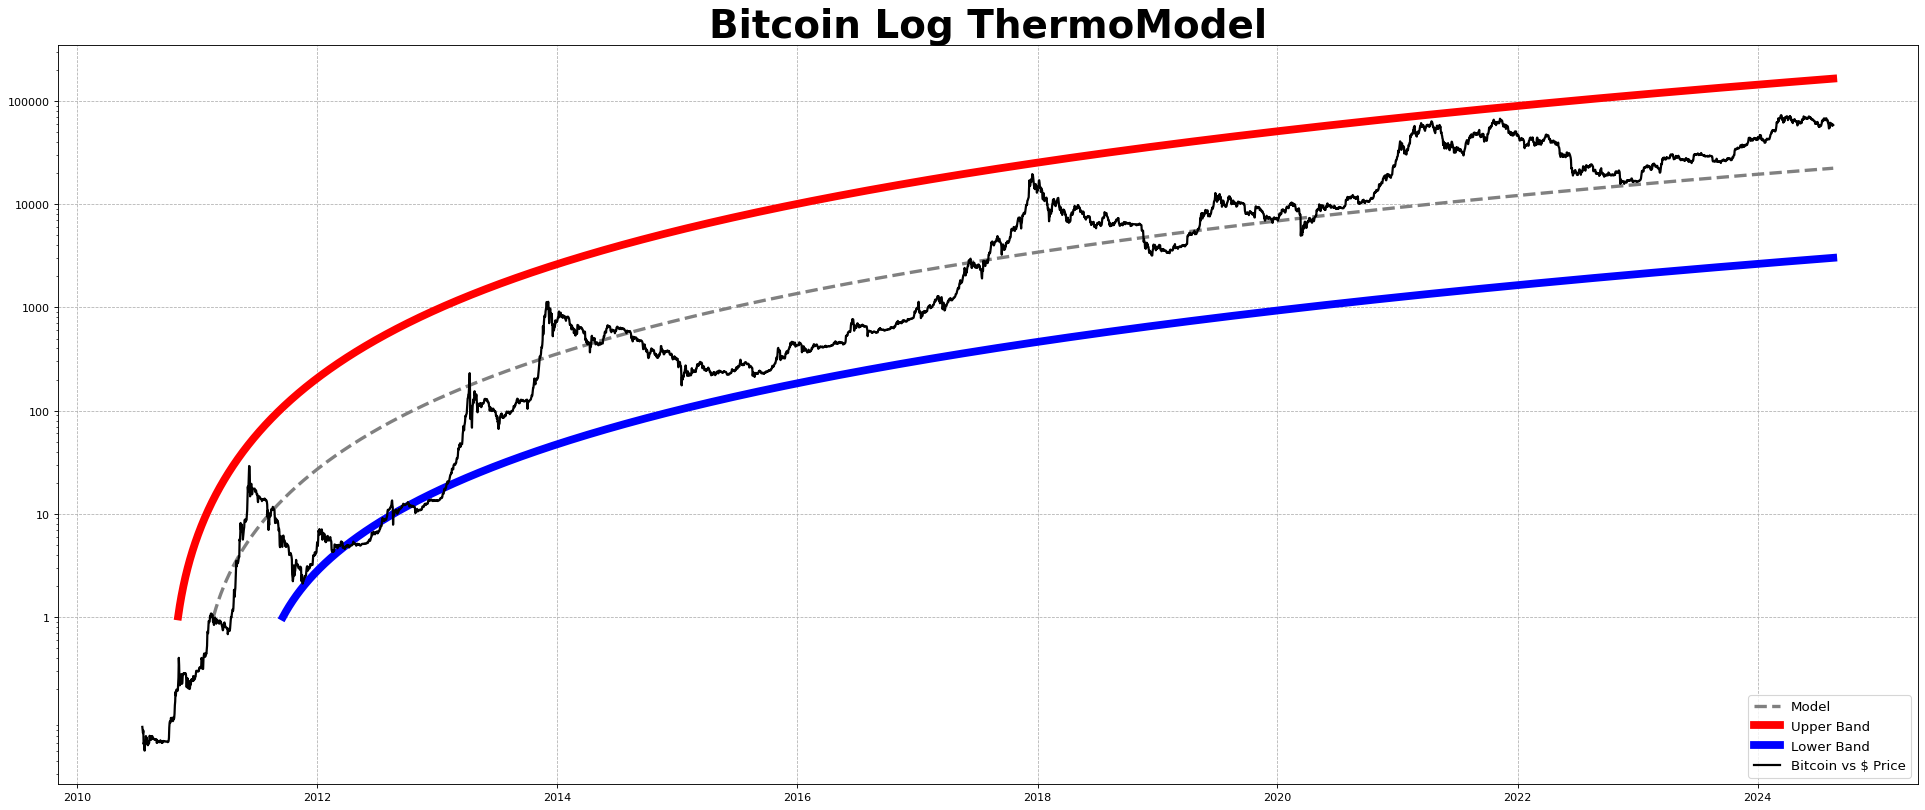

Fitted parameters on train data: {'coef': 2.9498175346916042, 'intercept': -15.19378537858838}


In [3]:
df, log_model_params = logarithmic_regression(
    df,
    upper=2,
    lower=-2,
    visualize_plot=True,
)

print("Fitted parameters on train data:", log_model_params)

# Ensemble Model Optimization Using Historical Tops and Bottoms
-----------------------------------------------------

In this section, I optimize the parameters of our ensemble model using historical price extremes (tops and bottoms) as reference points. This step is crucial for fine-tuning the model to capture significant turning points in the Bitcoin market, which are critical for predicting future price movements.

### Dates for Optimization

I specify dates that historically represent major top and bottom prices:

*   **Tops Dates**: These are the dates when Bitcoin reached peak prices.
*   **Bottoms Dates**: These are the dates when Bitcoin saw significant lows.

These dates are used to anchor our model during optimization, ensuring it captures these critical inflection points accurately.

### Optimization Parameters

*   **initial\_guess**: Initial estimates for the parameters, which guide the starting point of our optimization algorithm.
*   **bounds**: Constraints for each parameter to prevent overfitting and ensure the model remains generalizable.

### Optimization Goal

The objective is to minimize the mean absolute percentage error (MAPE) between the model's predictions and actual observed prices at these historical tops and bottoms. This process adjusts the model parameters to better align with Bitcoin's observed price behavior, improving predictive accuracy.

### Running the Optimization

The `optimize_params` function is used, which employs a boundary-limited version of the L-BFGS-B optimization algorithm, a popular choice for model fitting in machine learning due to its efficiency in handling potentially complex landscapes.

### Overview of Parameters and Their Interaction with Cubic and Log Models
`optimized_params` is an array of four values.
Let's dive in:


1.  **Upper Decay (`upper_decay`)**:
    
    *   **Role**: Controls the rate at which the influence of older data decreases for the upper band predictions.
    *   **Interaction**: Primarily affects the temporal dynamics of how both the cubic and log model predictions are integrated over time. A higher `upper_decay` value means that recent predictions (from both models) retain their influence longer, which could be crucial in volatile markets where recent trends are significant.
2.  **Upper Max Weight (`upper_maxw`)**:
    
    *   **Role**: Sets the maximum limit on the influence of the log model for the upper band.
    *   **Interaction**: By capping how much the log model can influence the upper band, this parameter indirectly enhances the relative influence of the cubic model when the log model's contribution is at its maximum threshold. Essentially, it adjusts the balance of influence between the cubic and log models for the upper prediction band.
3.  **Lower Decay (`lower_decay`)**:
    
    *   **Role**: Similar to the upper decay but for the lower prediction band, it dictates how quickly past influences diminish.
    *   **Interaction**: A positive `lower_decay` (as typically expected) would function similarly to the upper decay but for the lower band. If it's negative (which is unconventional), this could imply increasing influence over time, suggesting an atypical modeling choice where past trends grow in importance, potentially adjusting how both models' past outputs affect current predictions.
4.  **Lower Max Weight (`lower_maxw`)**:
    
    *   **Role**: Restricts the maximum impact of the log model on the lower band predictions.
    *   **Interaction**: A negative max weight unusually suggests that increases in the log model's output might inversely affect the ensemble's predictions, decreasing the lower band's predictions as the log model outputs higher values. This might be used to counter potential overshooting by the log model in downward trends, thereby stabilizing the lower band and giving more stabilizing control to the cubic model.

### Summary of Model Weighting Dynamics

In the ensemble model:

*   **Upper Band Weighting**: The combination of `upper_decay` and `upper_maxw` determines how responsive the upper band is to new data and how strongly the log model can peak within this band. The cubic model's influence increases as the log model's influence reaches the capped limit set by `upper_maxw`.
*   **Lower Band Weighting**: With `lower_decay` and `lower_maxw`, the dynamics are about stabilizing predictions against sharp downturns, where a conventional positive decay would smooth the integration of new data, and a typical positive max weight would limit log model's downward influence.

By adjusting these parameters, I can finely tune how aggressively or conservatively the ensemble model responds to market changes, leveraging strengths from both the cubic and log models to produce balanced and robust predictions. Remember that these four values are returned by the optimizer, which minimizes the MAPE (distance) between the bands and the prices provided.

In [4]:
# Dates for optimization
tops_dates = pd.to_datetime(["2011-06-08","2013-12-01", "2017-12-17", "2021-04-14"])
bottoms_dates = pd.to_datetime(["2011-11-19","2012-06-11","2013-01-01","2013-07-05","2016-08-02", "2018-12-15", "2022-11-09", "2022-09-11"])

initial_guess = [0.1, 0.72, -0.3, -0.05]
bounds = [(-1, 1), (-1, 1), (-1, 1), (-1, 1)]

# Run optimization
optimized_params = optimize_params(df, tops_dates, bottoms_dates, initial_guess, bounds)
optimized_params

array([ 1.        ,  0.67458406,  0.71241397, -0.47582189])

# Applying Models to the Full Dataset
-----------------------------------

After training our models on 95% of the available data, this section will demonstrate their performance on the entire dataset. This approach allows us to see how the models, fitted with parameters optimized on historical peaks and troughs, behave when exposed to the full scope of the newest data, using the learned parameters from the train set, on the full one.

### Full Dataset Loading

 Now I load the entire Bitcoin price dataset without splitting it into training and testing sets. This is done to evaluate the ensemble model's performance across all available data, including those portions not previously seen during the model training phase.

### Inference with Optimized Models

Using the `inference` function, I apply the optimized cubic and logarithmic models to the entire dataset. This step is crucial to visualize and understand how the parameters learned from the training subset perform when applied globally.

*   **cubic\_model\_params** and **log\_model\_params**: These parameters were optimized using data up to the 95% cut-off and include the regression coefficients and intercepts.
*   **optimized\_params**: Parameters from the ensemble optimization that dictate how the ensemble model combines the cubic and logarithmic models.

This process allows us to assess the predictive accuracy and robustness of our models across the entire historical price series of Bitcoin.

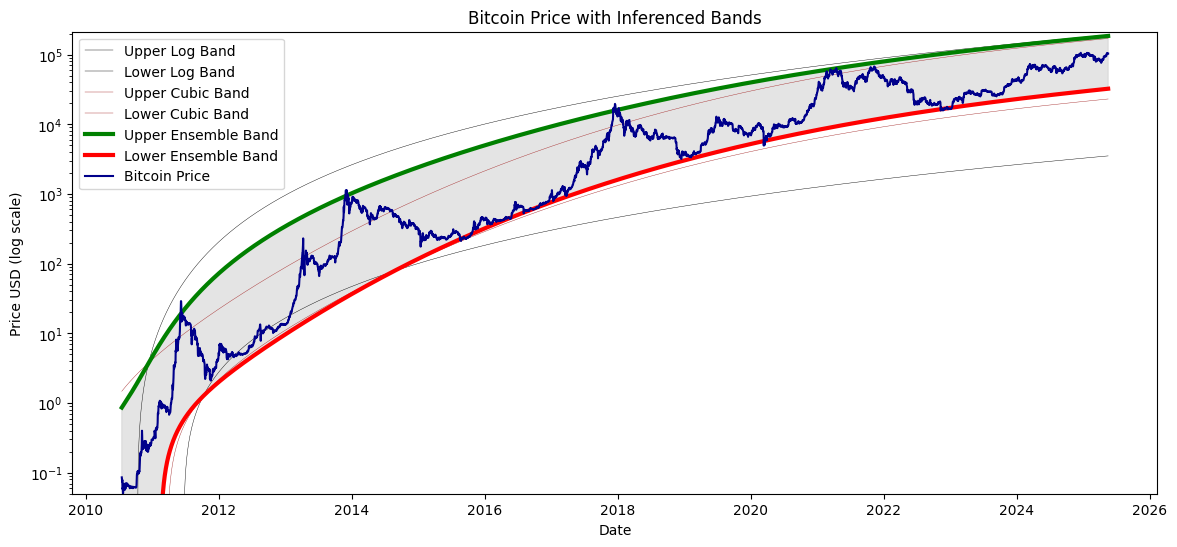

,time,PriceUSD,upper_cubic,lower_cubic,upper_log,lower_log,weights_upper,weights_lower,upper_cubiclog,lower_cubiclog,medium_cubiclog,sell_cubiclog,buy_cubiclog,75_cubiclog,25_cubiclog,Oscillator_cubiclog,lowess
5412,2025-05-12,102920.074689,170200.152781,23033.221219,191853.845242,3512.944064,0.674086,-0.475572,184796.604333,32316.510606,77278.596156,155226.917806,38472.589086,119502.393940,49973.738827,0.664328,0.612655
5413,2025-05-13,104145.711825,170300.916165,23046.858060,191958.415484,3514.859335,0.674211,-0.475634,184902.629651,32336.943819,77325.196068,155316.886521,38496.689452,119572.706298,50004.604999,0.670778,0.612134
5414,2025-05-14,103572.719642,170401.711530,23060.499229,192063.023393,3516.775296,0.674335,-0.475697,185008.692229,32357.384719,77371.812896,155406.887049,38520.798817,119643.043756,50035.482572,0.667273,0.611642
5415,2025-05-15,103716.283947,170502.538900,23074.144730,192167.668976,3518.691947,0.674460,-0.475759,185114.792084,32377.833310,77418.446648,155496.919404,38544.917187,119713.406328,50066.371555,0.667728,0.611188
5416,2025-05-16,103566.269191,170603.398295,23087.794565,192272.352239,3520.609288,0.674584,-0.475822,185220.929227,32398.289599,77465.097333,155586.983598,38569.044569,119783.794024,50097.271953,0.666558,0.610756


In [5]:
# Load the full dataset
df = load_btc_data(train_frac=1.0, last_date = False)
inference(df, cubic_model_params, log_model_params, optimized_params)
df.tail()

# Visualizing Weight Distributions in the Ensemble Model
------

The `weight_plot` function illustrates how weights applied in the ensemble model vary across the dataset, revealing how the model balances the influence of cubic and logarithmic regression outputs in its predictions.

### Purpose of Weight Plotting

Visualizing weights helps to:

*   **Demonstrate Variability**: Illustrate changes in weights over time, indicating shifts in model emphasis.
*   **Assess Model Dynamics**: Evaluate how the balance between cubic and logarithmic models adapts in response to data changes.

### Implementation Details

During the ensemble model's inference step, weights are calculated for both models. These weights dictate the influence of each model's output on the ensemble's predictions:

*   **Weights for Cubic Model**: Displayed against those for the logarithmic model to compare their influences.

### Formulas and Their Impacts

#### Upper Weights

$$
\text{weights\_upper} = e^{-\text{upper\_decay} \times \text{time\_index}} \times \text{upper\_maxw}
$$


 Here, `time_index` scales from 0 to 1 over the dataset.
*   **Impact**: A higher `upper_decay` leads to a slower decay rate, preserving the relevance of older predictions, which is crucial in trending markets. The `upper_maxw` parameter limits the maximum influence of the logarithmic model's predictions, ensuring a balance with the cubic model's output.

#### Lower Weights

$$
\text{weights\_lower} = e^{-\text{lower\_decay} \times \text{time\_index}} \times \text{lower\_maxw}
$$


A negative `lower_maxw` suggests that increased outputs from the logarithmic model could reduce the ensemble's lower band estimate.
*   **Impact**: The `lower_decay` parameter governs the rate at which older data's influence diminishes, stabilizing predictions against volatile market dips. The negative `lower_maxw` moderates the predictive band, preventing overly pessimistic reactions to new data.

### Summary

`weights_upper` and `weights_lower` are essential for tuning the ensemble model's sensitivity to new market information, ensuring robust predictions by effectively leveraging historical trends and recent changes with a dynamic weighting mechanism.

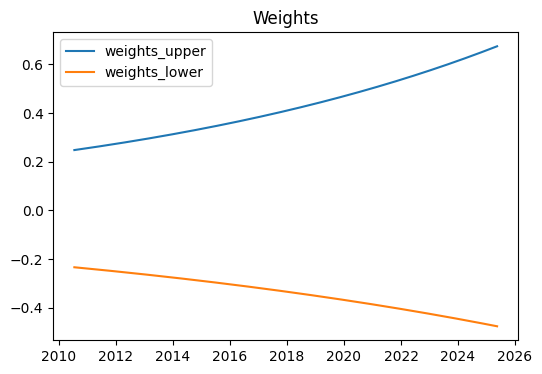

In [6]:
weight_plot(df)

# ThermoModel Visualization
-----------------------------------------------------

The `final_plot` function is designed to provide a comprehensive visualization of the ensemble model's predictions along with historical Bitcoin price data. This final visualization integrates various analytical insights and predicted bands, making it a powerful tool for interpreting the behavior and potential future movements of Bitcoin prices.

### Key Features of the Final Plot

*   **Price Bands**: Displays the ensemble model's predicted upper and lower bounds, along with intermediate quantile bands, highlighting potential resistance and support levels.
*   **Price Movements**: Plots the actual Bitcoin price against these bands to visually assess fit and predictive accuracy.
*   **Historical Halvings**: Marks significant dates of Bitcoin halving events which are known to impact price dynamics, providing contextual understanding of the price trends.
*   **Performance Indicators**: Includes a custom oscillator based on the price relative to the predicted bands, offering insights into overbought or oversold conditions.

### Purpose

This plot aims to:

*   **Synthesize Model Outputs**: Combine all model outputs and analytical layers into one cohesive visual representation.
*   **Enhance Decision Making**: Support investment decisions by visually representing critical thresholds and trend indicators.
*   **Validate Model Effectiveness**: Demonstrate how well the ensemble model captures the historical and potential future behavior of Bitcoin prices.

### Implementation Details

The function takes the full dataset and the optimized parameters, applying the ensemble model to generate detailed visualizations:

*   **last\_date**: The cutoff date used to highlight the training and inference segments within the dataset.

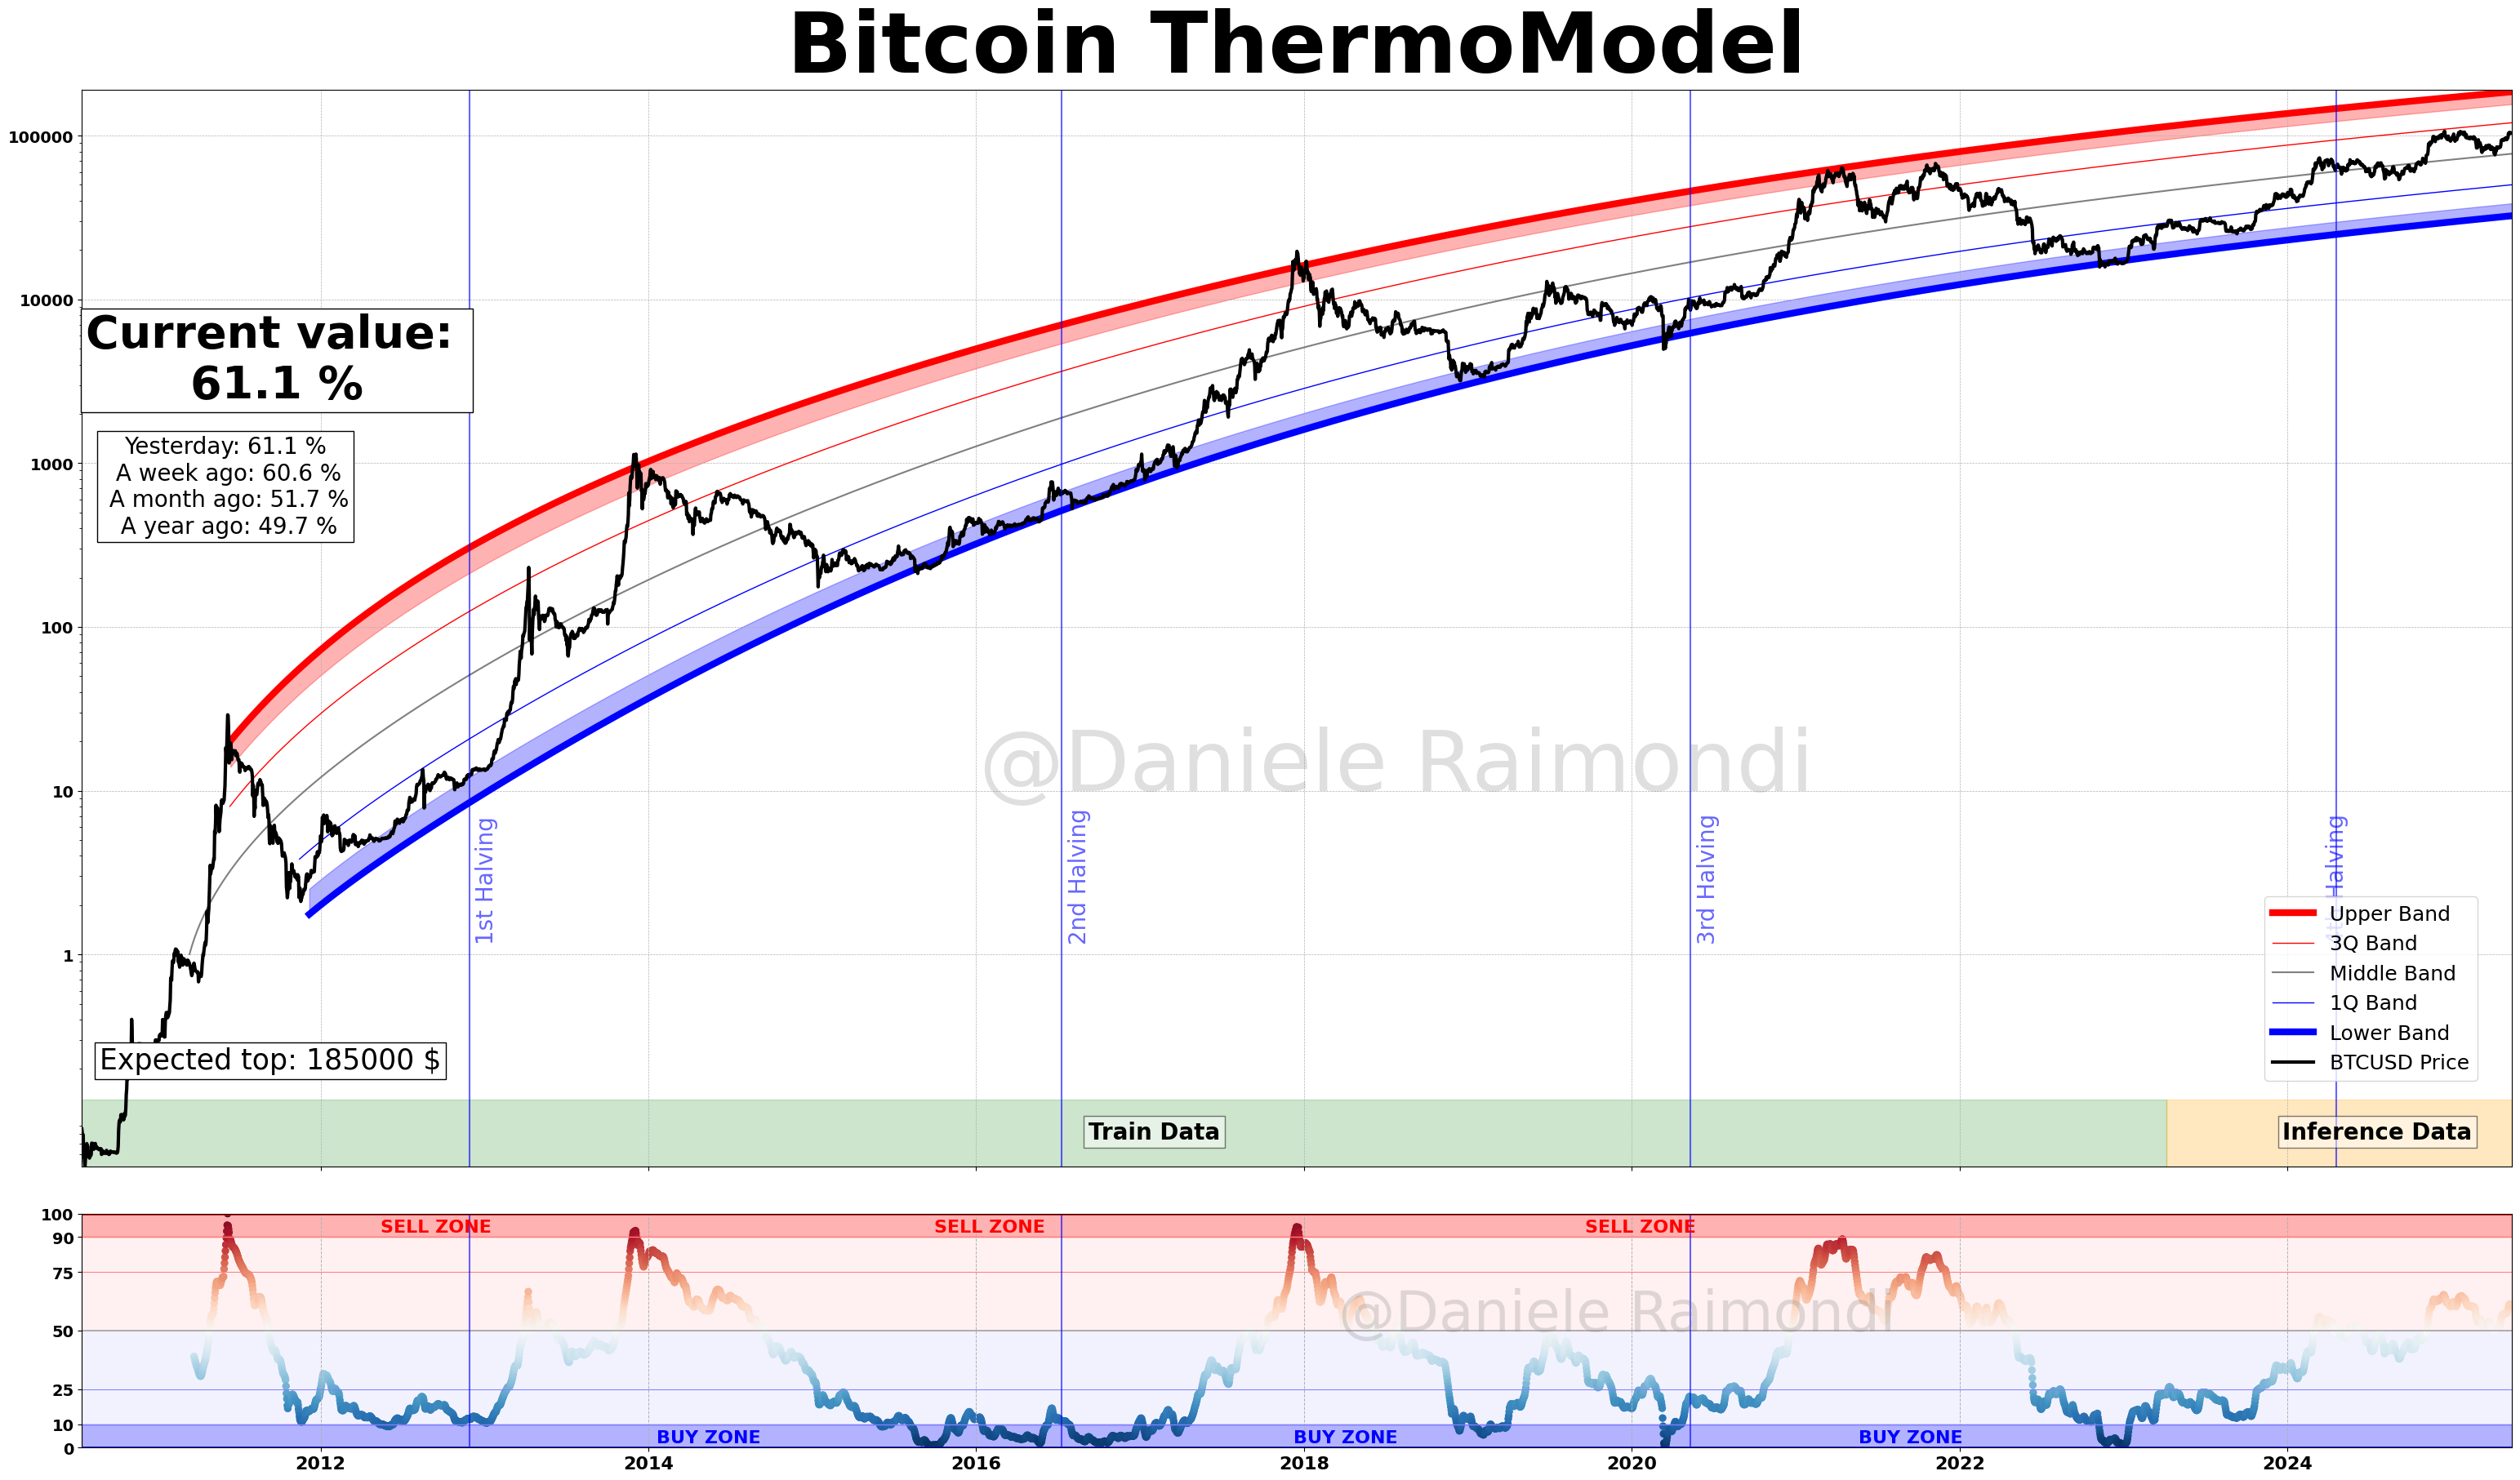

In [7]:
final_plot(df, last_date)

# Conclusions

Using the ensemble model that combines cubic and logarithmic regression techniques, we’ve gained a solid understanding of Bitcoin's price trends. This model effectively uses past data and recent market trends to predict future top and bottom price areas.

According to my model, Bitcoin could potentially reach an expected top of about **$150,000 USD**. This is a significant insight for investors and market analysts, suggesting a strong future performance.

While this prediction is useful, remember that it's based on current trends and historical data. Bitcoin is known for its volatility, and external economic factors can also play a big role. So, it’s wise to use these insights as part of a broader investment strategy.



Not a financial advice, just research.

In [8]:
df[["time", "PriceUSD", "lower_cubiclog", "upper_cubiclog"]].to_csv("/Users/danieleraimondi/bitcoin_datascience/data/thermomodel.csv", index=False)